# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [283]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
#!pip install jovian --upgrade --quiet

In [284]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [285]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [286]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [287]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [288]:
your_name = 'aash07' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [289]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [290]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
27,55,female,31.79175,2,no,northwest,14108.927088
997,63,female,35.74450,0,no,southeast,15971.163775
162,54,male,38.41200,1,no,southwest,12018.134800
824,60,male,23.59040,0,no,northwest,14402.145520
392,48,male,30.50165,1,no,northeast,10308.669633


In [291]:
dataframe['region'].unique()

array(['northwest', 'southeast', 'southwest', 'northeast'], dtype=object)

In [292]:
'''#since region is not much impactable on the given data, so I'm dropin region from dataframe
dataframe.drop(['region'], axis =1, inplace=True)'''

"#since region is not much impactable on the given data, so I'm dropin region from dataframe\ndataframe.drop(['region'], axis =1, inplace=True)"

In [293]:
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
27,55,female,31.79175,2,no,northwest,14108.927088
997,63,female,35.74450,0,no,southeast,15971.163775
162,54,male,38.41200,1,no,southwest,12018.134800
824,60,male,23.59040,0,no,northwest,14402.145520
392,48,male,30.50165,1,no,northeast,10308.669633


In [294]:
dataframe['smoker'].unique()

array(['no', 'yes'], dtype=object)

In [295]:
dataframe['sex'].unique()

array(['female', 'male'], dtype=object)

In [296]:
'''from sklearn.preprocessing import LabelEncoder
x1 = LabelEncoder()
dataframe['sex'] =x1.fit_transform(dataframe['sex'])
dataframe['smoker'] =x1.fit_transform(dataframe['smoker'])
dataframe.head()'''

"from sklearn.preprocessing import LabelEncoder\nx1 = LabelEncoder()\ndataframe['sex'] =x1.fit_transform(dataframe['sex'])\ndataframe['smoker'] =x1.fit_transform(dataframe['smoker'])\ndataframe.head()"

Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [297]:
# the shape is
dataframe.shape

(1271, 7)

In [298]:
num_rows = dataframe.shape[0]
print('number of rows are: \n',num_rows)

number of rows are: 
 1271


**Q: How many columns doe the dataset have**

In [299]:
num_cols = dataframe.shape[1]
print('number of columns are: \n',num_cols)

number of columns are: 
 7


**Q: What are the column titles of the input variables?**

In [300]:
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [301]:
input_cols = ['age', 'sex', 'bmi', 'children', 'region','smoker' ]
input_cols

['age', 'sex', 'bmi', 'children', 'region', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [302]:
categorical_cols = ['sex','region','smoker']

**Q: What are the column titles of output/target variable(s)?**

In [303]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [304]:
# Write your answer here
'''minimum'''
print('The minimum value for the charges is:\n',dataframe['charges'].min())

The minimum value for the charges is:
 1290.1549850000001


In [305]:
'''maximum'''
print('The maximum value for the charges is:\n',dataframe['charges'].max())

The maximum value for the charges is:
 73335.99221150001


In [306]:
'''average'''
print('The average value for the charges is:\n',dataframe['charges'].mean())

The average value for the charges is:
 15311.32460160413


#### Distrubution of values(charges) with respect to the sex and age:

In [307]:
from matplotlib.pyplot import plot
%matplotlib inline

In [308]:
## Sex
x = dataframe.groupby('sex')['charges'].mean()
x.head(2)

sex
female    14414.175717
male      16190.306920
Name: charges, dtype: float64

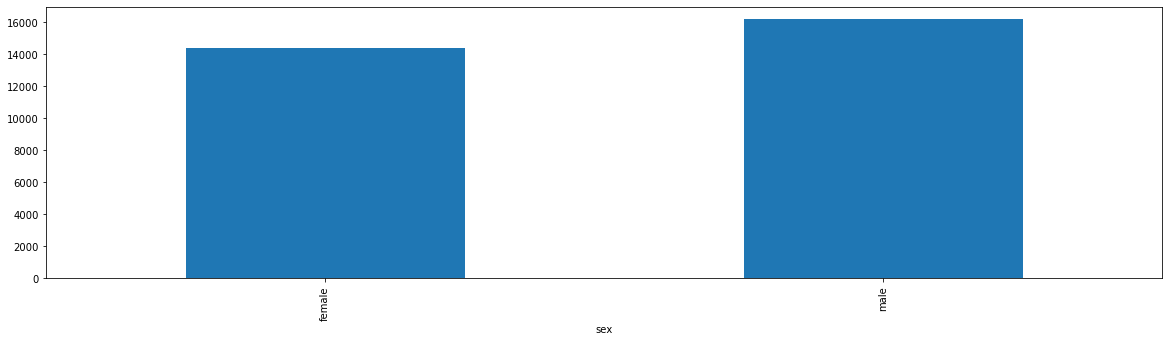

In [309]:
x.plot.bar(figsize=(20,5));

It is found to be average charges for male is greater than female

In [310]:
## age
y = dataframe.groupby('age')['charges'].mean()
y.head(2)

age
18     8421.506474
19    11489.281723
Name: charges, dtype: float64

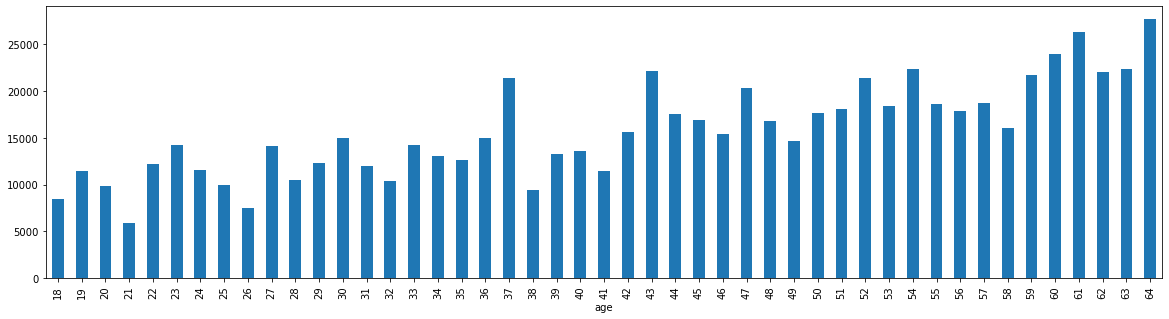

In [311]:
y.plot.bar(figsize=(20,5));

In above graph we can see average distrubution of charges with respect to their ages.

In [312]:
jovian.commit(project=project_name, environment=None)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [313]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [314]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.     ,  0.     , 31.79175,  2.     ,  1.     ,  0.     ],
        [63.     ,  0.     , 35.7445 ,  0.     ,  2.     ,  0.     ],
        [54.     ,  1.     , 38.412  ,  1.     ,  3.     ,  0.     ],
        ...,
        [58.     ,  1.     , 31.0497 ,  1.     ,  2.     ,  0.     ],
        [32.     ,  0.     , 42.8934 ,  0.     ,  2.     ,  0.     ],
        [35.     ,  1.     , 17.3242 ,  1.     ,  1.     ,  0.     ]]),
 array([[14108.9270875],
        [15971.163775 ],
        [12018.1348   ],
        ...,
        [13738.619785 ],
        [ 4593.30447  ],
        [ 5883.97546  ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [315]:
inputs = torch.tensor(inputs_array,dtype = torch.float32)
targets = torch.tensor(targets_array,dtype = torch.float32)

In [316]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [317]:
inputs.shape, targets.shape

(torch.Size([1271, 6]), torch.Size([1271, 1]))

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [318]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [319]:
val_percent = 0.17 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [1055, 216]) # Use the random_split function to split dataset into 2 parts of the desired length
val_size, train_size

(216, 1055)

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [320]:
batch_size = 35

In [321]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [322]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[24.0000,  0.0000, 22.5137,  0.0000,  2.0000,  0.0000],
        [56.0000,  1.0000, 39.0910,  0.0000,  3.0000,  0.0000],
        [64.0000,  1.0000, 24.8320,  2.0000,  3.0000,  0.0000],
        [60.0000,  0.0000, 23.7941,  0.0000,  2.0000,  0.0000],
        [38.0000,  1.0000, 27.0000,  2.0000,  1.0000,  0.0000],
        [28.0000,  0.0000, 25.0260,  0.0000,  3.0000,  0.0000],
        [25.0000,  0.0000, 40.0853,  0.0000,  0.0000,  0.0000],
        [57.0000,  0.0000, 27.9214,  4.0000,  0.0000,  0.0000],
        [19.0000,  1.0000, 43.5336,  0.0000,  2.0000,  1.0000],
        [19.0000,  1.0000, 33.0770,  0.0000,  3.0000,  0.0000],
        [27.0000,  1.0000, 44.5230,  2.0000,  3.0000,  0.0000],
        [23.0000,  1.0000, 23.7747,  0.0000,  0.0000,  0.0000],
        [24.0000,  1.0000, 34.7842,  0.0000,  2.0000,  0.0000],
        [27.0000,  1.0000, 28.2755,  0.0000,  2.0000,  1.0000],
        [19.0000,  0.0000, 28.9060,  0.0000,  3.0000,  0.0000],
        [50.0000,  0.0000, 43.40

Let's save our work by committing to Jovian.

In [323]:
jovian.commit(project=project_name, environment=None)

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [324]:
input_size = len(input_cols)
output_size = len(output_cols)

In [325]:
input_size,output_size

(6, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [338]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)   # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                         # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                  # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [339]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [340]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1328, -0.0695, -0.3510, -0.3957,  0.0298, -0.2680]],
        requires_grad=True), Parameter containing:
 tensor([0.0830], requires_grad=True)]

One final commit before we train the model.

In [341]:
jovian.commit(project=project_name, environment=None)

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [342]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [343]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15246.2919921875}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [344]:
epochs = 1000
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8867.0957
Epoch [40], val_loss: 8772.9482
Epoch [60], val_loss: 8688.9434
Epoch [80], val_loss: 8608.4990
Epoch [100], val_loss: 8535.9834
Epoch [120], val_loss: 8466.2510
Epoch [140], val_loss: 8397.5830
Epoch [160], val_loss: 8336.3340
Epoch [180], val_loss: 8288.6299
Epoch [200], val_loss: 8246.2627
Epoch [220], val_loss: 8212.3154
Epoch [240], val_loss: 8186.7993
Epoch [260], val_loss: 8169.9497
Epoch [280], val_loss: 8155.6382
Epoch [300], val_loss: 8146.7192
Epoch [320], val_loss: 8139.9600
Epoch [340], val_loss: 8134.7378
Epoch [360], val_loss: 8131.5894
Epoch [380], val_loss: 8128.1753
Epoch [400], val_loss: 8126.5669
Epoch [420], val_loss: 8125.1411
Epoch [440], val_loss: 8124.5132
Epoch [460], val_loss: 8121.8428
Epoch [480], val_loss: 8120.8550
Epoch [500], val_loss: 8119.4136
Epoch [520], val_loss: 8119.4321
Epoch [540], val_loss: 8118.2983
Epoch [560], val_loss: 8116.9155
Epoch [580], val_loss: 8116.8506
Epoch [600], val_loss: 8114.8130
Epoch [620], v

In [345]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8099.8511
Epoch [40], val_loss: 8099.7427
Epoch [60], val_loss: 8099.6460
Epoch [80], val_loss: 8099.4966
Epoch [100], val_loss: 8099.4165
Epoch [120], val_loss: 8099.2227
Epoch [140], val_loss: 8099.3203
Epoch [160], val_loss: 8099.2002
Epoch [180], val_loss: 8099.0713
Epoch [200], val_loss: 8099.1235
Epoch [220], val_loss: 8099.1460
Epoch [240], val_loss: 8098.9883
Epoch [260], val_loss: 8098.9102
Epoch [280], val_loss: 8098.7368
Epoch [300], val_loss: 8098.7578
Epoch [320], val_loss: 8098.6030
Epoch [340], val_loss: 8098.4912
Epoch [360], val_loss: 8098.5713
Epoch [380], val_loss: 8098.4385
Epoch [400], val_loss: 8098.2173
Epoch [420], val_loss: 8098.3252
Epoch [440], val_loss: 8098.1587
Epoch [460], val_loss: 8098.0923
Epoch [480], val_loss: 8097.8335
Epoch [500], val_loss: 8097.9312
Epoch [520], val_loss: 8097.8433
Epoch [540], val_loss: 8098.0503
Epoch [560], val_loss: 8097.7417
Epoch [580], val_loss: 8097.5327
Epoch [600], val_loss: 8097.5439
Epoch [620], v

In [346]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8096.2959
Epoch [40], val_loss: 8096.3110
Epoch [60], val_loss: 8096.3076
Epoch [80], val_loss: 8096.2808
Epoch [100], val_loss: 8096.2563
Epoch [120], val_loss: 8096.2432
Epoch [140], val_loss: 8096.2197
Epoch [160], val_loss: 8096.1812
Epoch [180], val_loss: 8096.1826
Epoch [200], val_loss: 8096.1772
Epoch [220], val_loss: 8096.1636
Epoch [240], val_loss: 8096.1528
Epoch [260], val_loss: 8096.1313
Epoch [280], val_loss: 8096.1367
Epoch [300], val_loss: 8096.1265
Epoch [320], val_loss: 8096.1138
Epoch [340], val_loss: 8096.1021
Epoch [360], val_loss: 8096.0991
Epoch [380], val_loss: 8096.0894
Epoch [400], val_loss: 8096.0933
Epoch [420], val_loss: 8096.0903
Epoch [440], val_loss: 8096.0776
Epoch [460], val_loss: 8096.0669
Epoch [480], val_loss: 8096.0732
Epoch [500], val_loss: 8096.0688
Epoch [520], val_loss: 8096.0688
Epoch [540], val_loss: 8096.0439
Epoch [560], val_loss: 8096.0552
Epoch [580], val_loss: 8096.0703
Epoch [600], val_loss: 8096.0742
Epoch [620], v

In [347]:
epochs = 1000
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8095.9111
Epoch [40], val_loss: 8095.9092
Epoch [60], val_loss: 8095.9087
Epoch [80], val_loss: 8095.9072
Epoch [100], val_loss: 8095.9067
Epoch [120], val_loss: 8095.9062
Epoch [140], val_loss: 8095.9053
Epoch [160], val_loss: 8095.9038
Epoch [180], val_loss: 8095.9028
Epoch [200], val_loss: 8095.9023
Epoch [220], val_loss: 8095.8994
Epoch [240], val_loss: 8095.8994
Epoch [260], val_loss: 8095.8960
Epoch [280], val_loss: 8095.8945
Epoch [300], val_loss: 8095.8916
Epoch [320], val_loss: 8095.8901
Epoch [340], val_loss: 8095.8877
Epoch [360], val_loss: 8095.8882
Epoch [380], val_loss: 8095.8862
Epoch [400], val_loss: 8095.8853
Epoch [420], val_loss: 8095.8838
Epoch [440], val_loss: 8095.8853
Epoch [460], val_loss: 8095.8857
Epoch [480], val_loss: 8095.8838
Epoch [500], val_loss: 8095.8818
Epoch [520], val_loss: 8095.8843
Epoch [540], val_loss: 8095.8833
Epoch [560], val_loss: 8095.8838
Epoch [580], val_loss: 8095.8804
Epoch [600], val_loss: 8095.8804
Epoch [620], v

In [348]:
epochs = 1000
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8095.8726
Epoch [40], val_loss: 8095.8726
Epoch [60], val_loss: 8095.8726
Epoch [80], val_loss: 8095.8721
Epoch [100], val_loss: 8095.8721
Epoch [120], val_loss: 8095.8735
Epoch [140], val_loss: 8095.8735
Epoch [160], val_loss: 8095.8735
Epoch [180], val_loss: 8095.8740
Epoch [200], val_loss: 8095.8740
Epoch [220], val_loss: 8095.8735
Epoch [240], val_loss: 8095.8735
Epoch [260], val_loss: 8095.8740
Epoch [280], val_loss: 8095.8740
Epoch [300], val_loss: 8095.8740
Epoch [320], val_loss: 8095.8740
Epoch [340], val_loss: 8095.8740
Epoch [360], val_loss: 8095.8735
Epoch [380], val_loss: 8095.8726
Epoch [400], val_loss: 8095.8726
Epoch [420], val_loss: 8095.8740
Epoch [440], val_loss: 8095.8740
Epoch [460], val_loss: 8095.8740
Epoch [480], val_loss: 8095.8740
Epoch [500], val_loss: 8095.8740
Epoch [520], val_loss: 8095.8740
Epoch [540], val_loss: 8095.8740
Epoch [560], val_loss: 8095.8740
Epoch [580], val_loss: 8095.8740
Epoch [600], val_loss: 8095.8740
Epoch [620], v

**Q: What is the final validation loss of your model?**

Text(0, 0.5, 'losses')

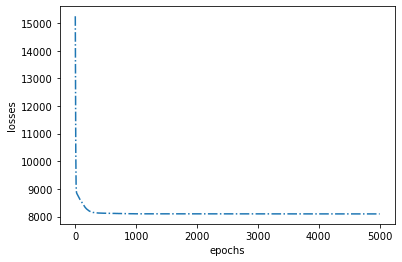

In [352]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5
val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-.')

plt.xlabel('epochs')
plt.ylabel('losses')

Let's log the final validation loss to Jovian and commit the notebook

In [353]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [354]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [355]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([46.0000,  0.0000, 19.3515,  2.0000,  1.0000,  0.0000])
Target: tensor([10572.9141])
Prediction: tensor([11736.8682])


In [356]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([32.0000,  0.0000, 22.9405,  1.0000,  2.0000,  0.0000])
Target: tensor([20270.1758])
Prediction: tensor([7146.7432])


In [357]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([25.0000,  0.0000, 23.5710,  3.0000,  3.0000,  0.0000])
Target: tensor([5050.3999])
Prediction: tensor([5150.0962])


Are you happy with your model's predictions? Try to improve them further.

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Creating a new project "aakashns/02-insurance-linear-regression"
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/aakashns/02-insurance-linear-regression


<IPython.core.display.Javascript object>